In [ ]:
import numpy as np
import torch
import mrcfile
import matplotlib.pyplot as plt
from pathlib import Path
from torch_tiltxcorr import tiltxcorr

In [ ]:
def read_imod_xg(path):
    rows = []
    with open(path) as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            parts = line.split()
            rows.append((float(parts[5]), float(parts[4])))
    return np.asarray(rows, dtype=np.float32)

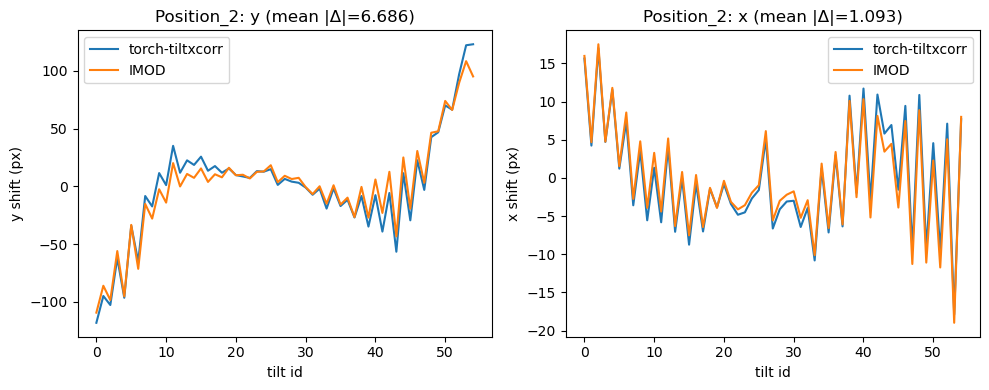

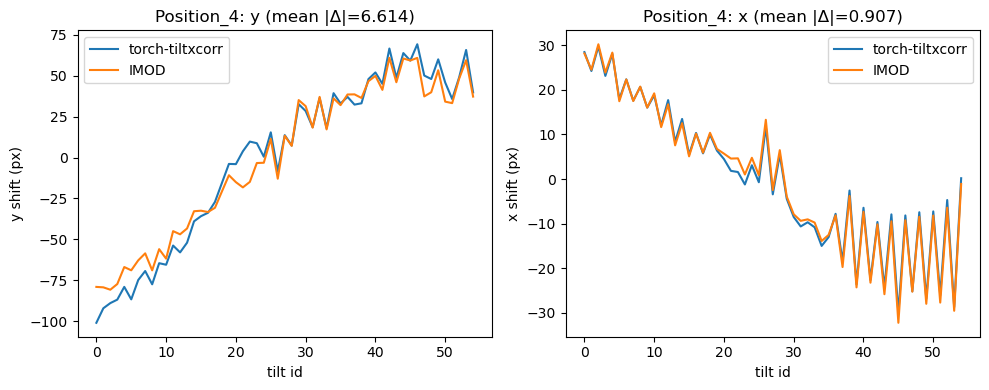

In [ ]:
tilt_axis_angle = 95.86
device = "cpu"
bases = ["Position_2", "Position_4"]

for base in bases:
    mrc_path = Path(f"{base}.mrc")
    tlt_path = Path(f"{base}_st.tlt")
    xg_path = Path(f"{base}.xg")

    with mrcfile.open(mrc_path, permissive=True) as m:
        data = m.data.astype(np.float32)

    angles = np.loadtxt(tlt_path, dtype=np.float32)
    if angles.shape[0] != data.shape[0]:
        raise ValueError(f"{base}: n_angles={angles.shape[0]} != n_slices={data.shape[0]}")

    tilt_series = torch.from_numpy(data).to(device)
    tilt_angles = torch.from_numpy(angles).to(device)

    torch_shifts = tiltxcorr(
        tilt_series=tilt_series,
        tilt_angles=tilt_angles,
        tilt_axis_angle=tilt_axis_angle,
        low_pass_cutoff=0.25,
    )
    torch_shifts = torch_shifts - torch_shifts.mean(dim=0, keepdim=True)

    imod_shifts = torch.from_numpy(read_imod_xg(xg_path)).to(device)
    imod_shifts = imod_shifts - imod_shifts.mean(dim=0, keepdim=True)

    torch_cpu = torch_shifts.detach().cpu().numpy()
    imod_cpu = imod_shifts.detach().cpu().numpy()

    abs_diff = np.abs(torch_cpu - imod_cpu)
    mean_abs = abs_diff.mean(axis=0)

    t = np.arange(data.shape[0])

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(t, torch_cpu[:, 0], label="torch-tiltxcorr")
    ax[0].plot(t, imod_cpu[:, 0], label="IMOD")
    ax[0].set_xlabel("tilt id")
    ax[0].set_ylabel("y shift (px)")
    ax[0].set_title(f"{base}: y (mean |Δ|={mean_abs[0]:.3f})")
    ax[0].legend()

    ax[1].plot(t, torch_cpu[:, 1], label="torch-tiltxcorr")
    ax[1].plot(t, imod_cpu[:, 1], label="IMOD")
    ax[1].set_xlabel("tilt id")
    ax[1].set_ylabel("x shift (px)")
    ax[1].set_title(f"{base}: x (mean |Δ|={mean_abs[1]:.3f})")
    ax[1].legend()

    plt.tight_layout()
    plt.show()